In [1]:
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plot_config
plot_config.set_config()

In [2]:
experiment = 'elec2'
name_caps = 'Electricity'

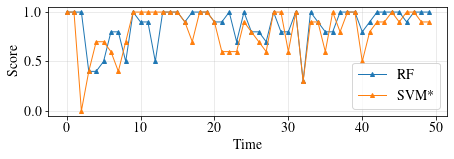

In [14]:
rf_score = load('../data/'+experiment+'/score_rf.joblib')[:50]
svm_score = load('../data/'+experiment+'/score_svm.joblib')[:50]
fig = plt.gcf()
fig.set_size_inches(7.14, 2)
plt.plot(rf_score, '^-', label='RF')
plt.plot(svm_score, '^-', label='SVM*')
plt.xlabel('Time')
plt.ylabel('Score')
plt.legend(fancybox=True)
plt.savefig(experiment+'_tscores.pdf', bbox_inches='tight')

In [4]:
t_importance = load('../data/'+experiment+'/importance.joblib')
t_fname = load('../data/'+experiment+'/fnames.joblib')[:-1]
dic = sorted([(k,v) for k,v in zip(t_importance, t_fname)])[-15:]
importance = [k for k,v in dic]
fname = [v for k,v in dic]
pos = np.arange(len(importance))

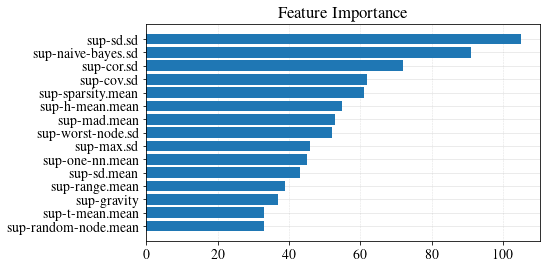

In [5]:
fig, ax1 = plt.subplots()
fig.subplots_adjust(left=0.115, right=0.88)
ax1.set_title('Feature Importance')
ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
rects = plt.barh(pos, importance,
         align='center',
         tick_label=[x.replace('_','-') for x in fname])
fig = plt.gcf()
fig.set_size_inches(7.14, 4)
plt.savefig(experiment+'_fi.pdf', bbox_inches='tight')

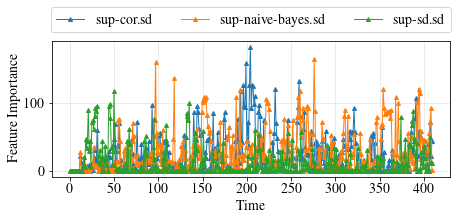

In [6]:
tfi = load('../data/'+experiment+'_ninc/tfi.joblib')
topfname = fname[-3:]
tfi = pd.DataFrame(tfi, columns=t_fname)[topfname]
tfi.rename(columns={x:x.replace('_','-') for x in topfname}, inplace=True)
ax = tfi.plot(style='^-')
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Time')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3, fancybox=True)
fig = plt.gcf()
fig.set_size_inches(7.14, 2.5)
plt.savefig(experiment+'_timefi.pdf', bbox_inches='tight')

In [7]:
arange = 1000
difference = np.array(load('../data/'+experiment+'/difference.joblib'))
difference_ninc = np.array(load('../data/'+experiment+'_ninc/difference.joblib'))
cum = np.cumsum(difference)[:arange]
cum_ninc = np.cumsum(difference_ninc)[:arange]
x = np.arange(arange)

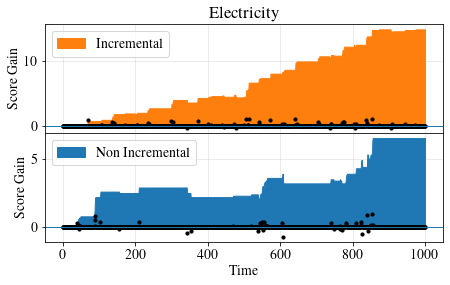

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 4), sharex=True, gridspec_kw={'hspace': 0})

ax1.fill_between(x, cum, 0, color='C1', label='Incremental')
ax1.scatter(x, difference[:arange], s=10, c='black')
ax1.set_title(name_caps)
ax1.axhline(0)
ax1.legend(loc='upper left')
ax1.set_ylabel('Score Gain')

ax2.fill_between(x, cum_ninc, 0, color='C0', label='Non Incremental')
ax2.scatter(x, difference_ninc[:arange], s=10, c='black')
ax2.axhline(0)
ax2.legend(loc='upper left')
ax2.set_ylabel('Score Gain')
ax2.set_xlabel('Time')

fig = plt.gcf()
fig.set_size_inches(7.14, 4)
plt.savefig(experiment+'_cumsum.pdf', bbox_inches='tight')

In [9]:
print(cum[-10:])

[15. 15. 15. 15. 15. 15. 15. 15. 15. 15.]


In [10]:
with open('../'+experiment.replace('_','-')+'.output') as fin:
    print(fin.read())

[FINETUNING BASE MODELS]
[GENERATE METAFEATURE]
Frequency statistics in metabase:
	Pipeline                 0.752
	RandomForestClassifier   0.247
[OFFLINE LEARNING]
Kappa:    0.228
GMean:    0.524
Accuracy: 0.740
[[66  8]
 [18  8]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        74
           1       0.50      0.31      0.38        26

    accuracy                           0.74       100
   macro avg       0.64      0.60      0.61       100
weighted avg       0.71      0.74      0.72       100

                   pre       rec       spe        f1       geo       iba       sup

          0       0.79      0.89      0.31      0.84      0.52      0.29        74
          1       0.50      0.31      0.89      0.38      0.52      0.26        26

avg / total       0.71      0.74      0.46      0.72      0.52      0.28       100

[ONLINE LEARNING]
Kappa:  0.03310809793977343
GMean:  0.4413630358684599
Accuracy:  0.6447207998049256
   

In [11]:
metadf = load('../data/'+experiment+'/metadf.joblib')
best = np.array(load('../data/'+experiment+'/best.joblib'))
score_recommended = np.array(load('../data/'+experiment+'/score_reco.joblib'))
score_default = np.array(load('../data/'+experiment+'/score_def.joblib'))


score_recommended_ninc = np.array(load('../data/'+experiment+'_ninc/score_reco.joblib'))
score_default_ninc = np.array(load('../data/'+experiment+'_ninc/score_def.joblib'))

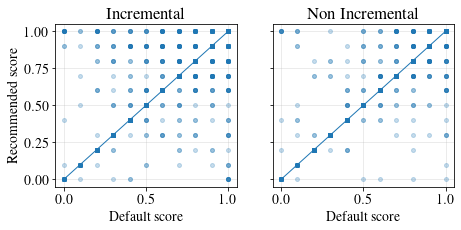

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

ax1.scatter(score_default, score_recommended, alpha=.25)
ax1.set_ylabel('Recommended score')
ax1.set_title('Incremental')
ax1.set_xlabel('Default score')
ax1.plot([0,1])

ax2.scatter(score_default_ninc, score_recommended_ninc, alpha=.25)
ax2.set_title('Non Incremental')
ax2.set_xlabel('Default score')
ax2.plot([0,1])

fig = plt.gcf()
fig.set_size_inches(7.14, 3)
plt.savefig(experiment+'_score.pdf', bbox_inches='tight')

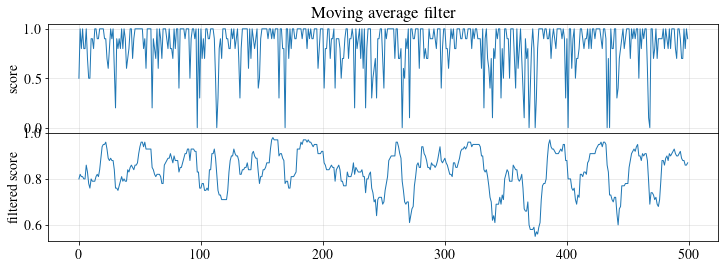

In [13]:
window_score = 500
N = 10
n_feats = 5
sorted_feats = np.argsort(t_importance)[::-1]
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 4), sharex=True, gridspec_kw={'hspace': 0})
ax1.plot(score_default[-window_score:])
moving_avg = np.convolve(score_default[-(window_score+N-1):], np.ones((N,))/N, mode='valid')
ax2.plot(moving_avg)
ax1.set_title('Moving average filter')
ax1.set_ylabel('score')
ax2.set_ylabel('filtered score')
plt.savefig(experiment+'_smovingavg.pdf', bbox_inches='tight')